In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

In [2]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import DMatrix
from sklearn.metrics import mean_squared_error as MSE
from catboost import CatBoostRegressor

In [3]:
# Se cargan los datos
train = pd.read_csv('D:\Kaggle\house prices/train.csv', index_col='Id')
test = pd.read_csv('D:\Kaggle\house prices/test.csv', index_col='Id')

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Estos datos pandas los habia reconocido como numericos pero son categoricos
train = train.astype({'MSSubClass':object,'OverallQual':object,'OverallCond':object})

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
TotalBsmtSF,1460.0,1057.429452,438.705324,0.0,795.75,991.5,1298.25,6110.0
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   object 
 17  OverallCond    1460 non-null   object 
 18  YearBuil

In [7]:
# Como son muchas columnas se quiere mostrar solo las que tienen valores nulos 
null = train.isnull().sum()
col_null = null[null > 0].index
col_null = null[col_null]
#print(col_null)

In [8]:
#Se borran las columnas con demasiados datos faltantes
list_drop = col_null.index[np.where(col_null > 500)[0]].tolist()
train = train.drop(labels=list_drop, axis=1)
test = test.drop(labels=list_drop, axis=1)
train.shape

(1460, 75)

In [9]:
# Se muestran nuevamente solo las columnas con valores nulos
null = train.isnull().sum()
col_null = null[null > 0].index
col_null = null[col_null]
#print(col_null)


In [10]:
# Se elimina el 5% de las filas 
threshold = len(train) * 0.05  
col_drop = train.columns[train.isna().sum() <= threshold]
train.dropna(subset=col_drop, inplace=True)
print(train.shape)
train.isna().sum().sort_values(ascending=False)

(1412, 75)


LotFrontage     251
GarageFinish     74
GarageType       74
GarageQual       74
GarageCond       74
               ... 
ExterQual         0
MasVnrArea        0
MasVnrType        0
Exterior2nd       0
SalePrice         0
Length: 75, dtype: int64

In [11]:
# Se muestran nuevamente solo las columnas con valores nulos y se hace una lista con ellas
null = train.isnull().sum()
col_null = null[null > 0].index
col_null = null[col_null]
#print(col_null)
lista_null = list(col_null.index)
#print(lista_null)
#train[col_null.index].info()

###  Division  de los datos en features y label

In [12]:
y_train = train.SalePrice
train = train.drop(['SalePrice'], axis=1)

In [13]:
#Se define una funcion para graficar cada columna y determinar el tipo de imputacion de los valores nulos
def graf_imp(lista):
    from math import ceil
    cant_col = 2
    filas = ceil(len(lista) / cant_col)
    fig, axs = plt.subplots(nrows=filas, ncols=cant_col, figsize= (12, 5*filas))
    idx = 0
    for i in range(filas):
        for j in range(cant_col):
            if idx < len(lista):
                col = lista[idx]
                sns.histplot(x=train[col], data=train, ax=axs[i][j])
                idx += 1
    plt.show()

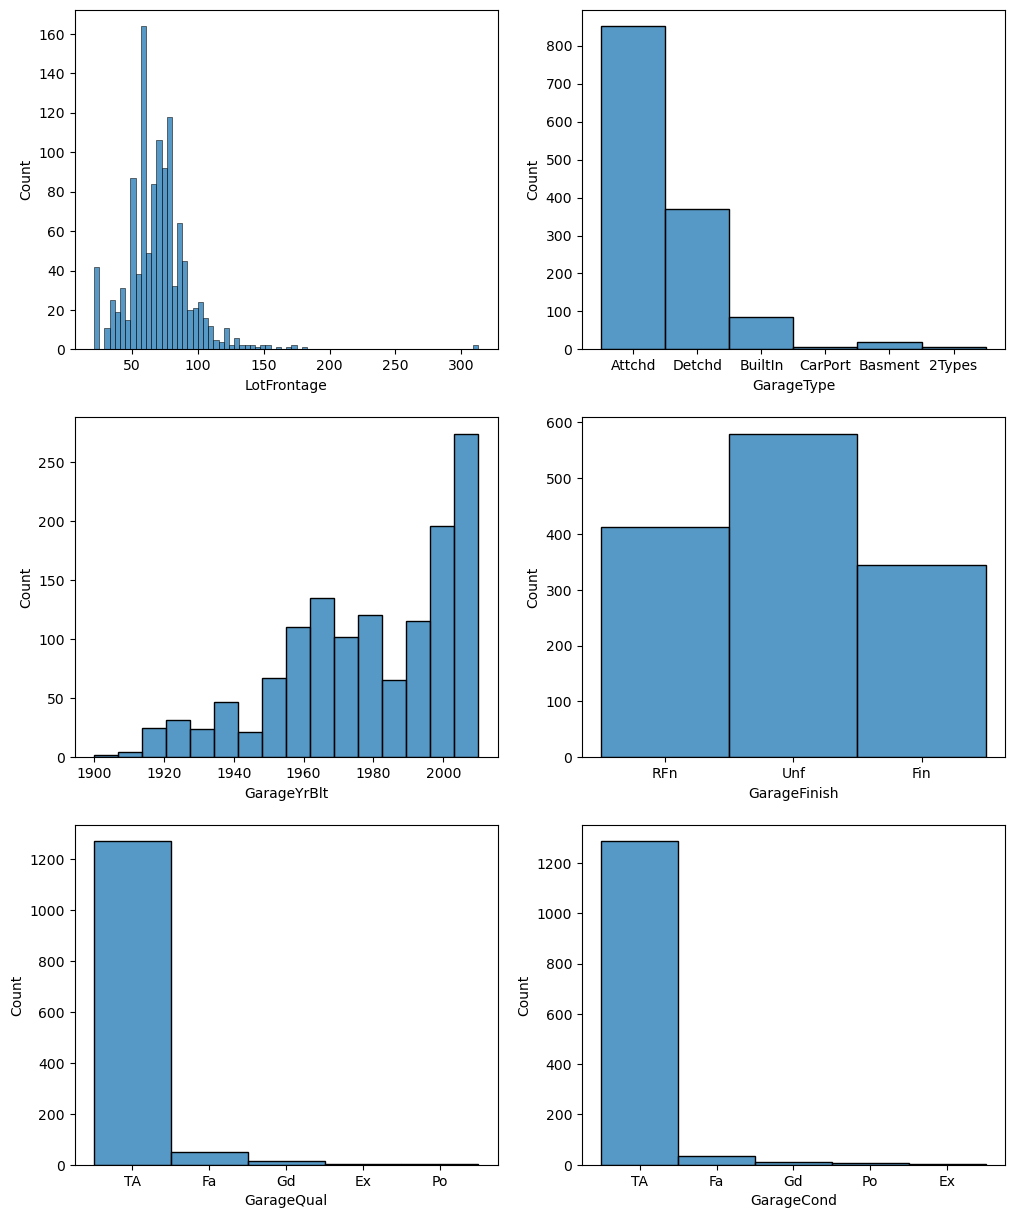

In [14]:
graf_imp(lista_null)

 Teniendo en cuenta las graficas anteriores:
    * GarageQual, GarageCond, GarageType se usara la imputacion  mas frecuente 
    * GarageFinish se hara aleatorio  
    * LotFrontage y GarageYrBlt se hara con la mediana

In [15]:
#Imputacion variables categoricas
list_cat =['GarageQual', 'GarageCond', 'GarageType']
def imp_cat (lista_cat):
    train.loc[:, lista_cat] = train[lista_cat].fillna(train[lista_cat].mode().iloc[0])
imp_cat(list_cat)

In [16]:
# Imputacion aleatoria
np.random.seed(123)
garage_finish = train['GarageFinish']
categorias = garage_finish.dropna().unique()
muestra = np.random.choice(categorias, size=train['GarageFinish'].isnull().sum())
train.loc[train['GarageFinish'].isnull(), 'GarageFinish'] = muestra

In [17]:
# Imputacion numerica
list_num =['LotFrontage', 'GarageYrBlt']
def imp_num (lista_num):
    train.loc[:, lista_num] = train[lista_num].fillna(train[lista_num].median().iloc[0])
imp_cat(list_num)

In [18]:
# Se verifica que no hay valores nulos
train.isna().sum().sort_values(ascending=False)

MSSubClass       0
GarageType       0
Functional       0
TotRmsAbvGrd     0
KitchenQual      0
                ..
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
SaleCondition    0
Length: 74, dtype: int64

In [19]:
# Se verifica cuantas columnas y filas tiene el df
print(train.shape)

(1412, 74)


In [20]:
# Se divide el data set en caracteristicas categoricas y numericas
train_num = train.select_dtypes(include=np.number)
train_cat = train.select_dtypes(include='object')
print(train_num.shape)
print(train_cat.shape)

(1412, 33)
(1412, 41)


In [21]:
# Codificacion para aplicar el metodo Anova
label = LabelEncoder()
train_cat_array = train_cat.apply(label.fit_transform)
train_cat_array.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,5,3,1,3,3,0,4,0,5,2,...,4,2,6,1,1,4,4,2,8,4
2,0,3,1,3,3,0,2,0,24,1,...,4,3,6,1,1,4,4,2,8,4
3,5,3,1,0,3,0,4,0,5,2,...,4,2,6,1,1,4,4,2,8,4
4,6,3,1,0,3,0,0,0,6,2,...,4,2,6,5,2,4,4,2,8,0
5,5,3,1,0,3,0,2,0,15,2,...,4,2,6,1,1,4,4,2,8,4


In [22]:
# Anova aplicado con scikit-learn a variables categoricas
k_best = SelectKBest(score_func=f_regression, k=30)
k_best.fit_transform(train_cat_array, y_train)

anova_score = pd.DataFrame({'Anova_score':k_best.scores_, 'P_value_anova': k_best.pvalues_}, index=train_cat.columns)
anova_score.sort_values(by=['P_value_anova'], ascending=False)

,Anova_score,P_value_anova
Condition2,0.069296,7.924031e-01
LandContour,0.300951,5.833739e-01
Utilities,0.322431,5.702405e-01
MasVnrType,0.856279,3.549405e-01
BsmtFinType2,2.280827,1.312060e-01
Street,2.627585,1.052449e-01
MSSubClass,3.335272,6.802056e-02
SaleType,3.386061,6.595990e-02
LandSlope,3.873823,4.924035e-02
BsmtFinType1,5.726724,1.683877e-02


In [23]:
# Se asigna el umbral y se guardan las caracteristicas que esten por encima de el.
p_value = 0.05
drop_cat = anova_score[anova_score['P_value_anova'] >= p_value].index
drop_cat

Index(['MSSubClass', 'Street', 'LandContour', 'Utilities', 'Condition2',
       'MasVnrType', 'BsmtFinType2', 'SaleType'],
      dtype='object')

In [24]:
# Se borran estas caracteristicas porque no son significativas
train = train.drop(columns=drop_cat, axis=1)
test = test.drop(columns=drop_cat, axis=1)
print(train.shape)
print(test.shape)

(1412, 66)
(1459, 66)


In [25]:
# Anova aplicado con scikit-learn a variables numericas
k_best_num = SelectKBest(score_func=f_regression, k=25)
k_best_num.fit_transform(train_num, y_train)

anova_score_num = pd.DataFrame({'Anova_score_num':k_best_num.scores_, 'P_value_anova_num': k_best_num.pvalues_}, 
                           index=train_num.columns)
anova_score_num.sort_values(by=['P_value_anova_num'], ascending=False)

,Anova_score_num,P_value_anova_num
MiscVal,0.248973,6.178767e-01
BsmtFinSF2,0.575361,4.482632e-01
BsmtHalfBath,0.688545,4.068002e-01
YrSold,0.769924,3.803901e-01
LowQualFinSF,1.140408,2.857489e-01
MoSold,2.462441,1.168218e-01
3SsnPorch,3.126884,7.722702e-02
PoolArea,12.241700,4.818707e-04
KitchenAbvGr,15.944250,6.859700e-05
ScreenPorch,16.705274,4.612166e-05


In [26]:
# Se asigna el umbral y se guardan las caracteristicas que esten por encima de el.
p_value_num = 0.05
drop_num = anova_score_num[anova_score_num['P_value_anova_num'] >= p_value_num].index
drop_num

Index(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [27]:
# Se borran estas caracteristicas porque no son significativas
train = train.drop(columns=drop_num, axis=1)
test = test.drop(columns=drop_num, axis=1)
print(train.shape)
print(test.shape)

(1412, 59)
(1459, 59)


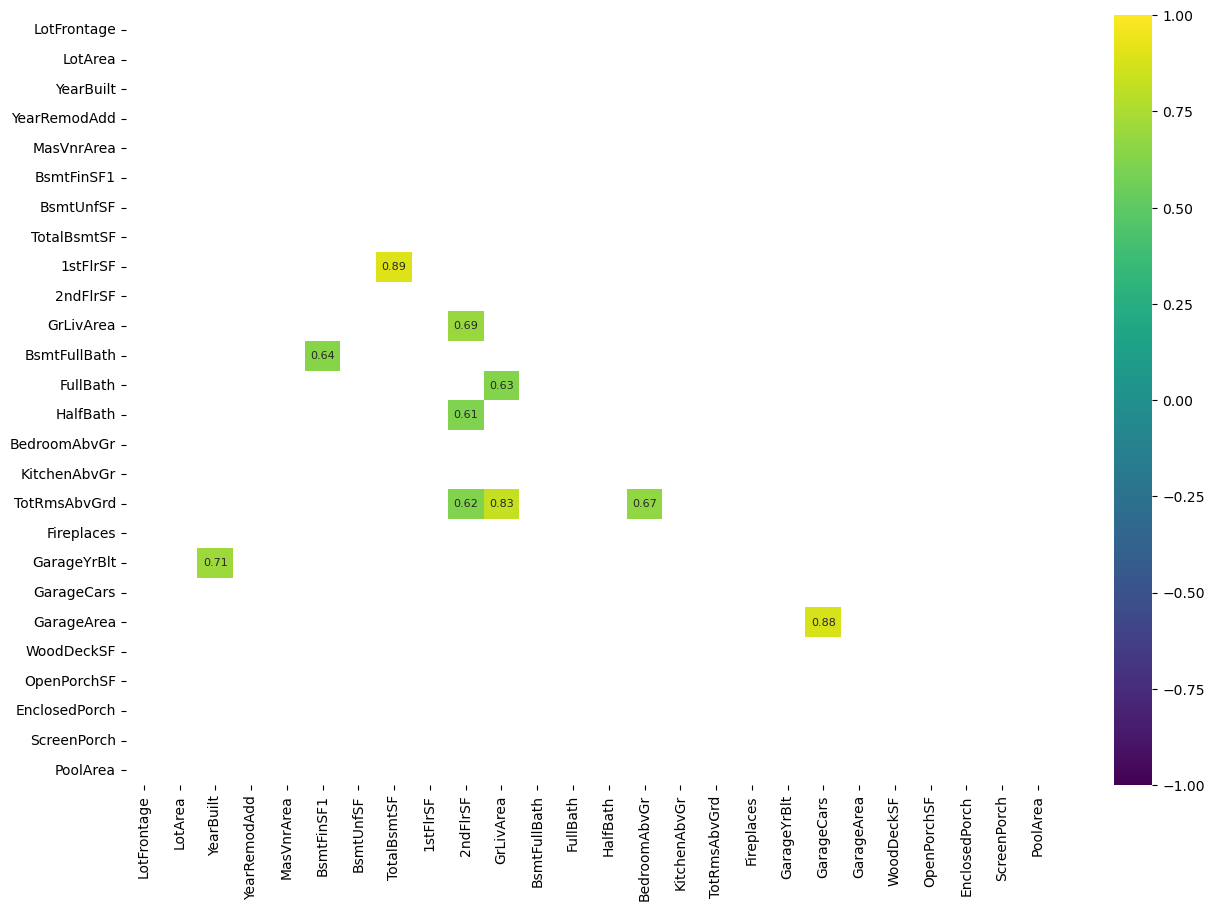

In [28]:
# Se traza un heatmap para ver las correelaciones entre features, solo se traza la mitad 
plt.figure(figsize=(15,10))
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr[(corr>=0.6) | (corr <= -0.6)], annot=True, cmap='viridis', vmax=1.0, vmin=-1.0, annot_kws={"size": 8}, 
            mask=mask)
plt.show()

# Se arma la lista de tuplas de los features, con una correlacion mayor a 0.6
corr = corr.mask(mask)
mask_1 = corr > 0.6
cols_corr = []
for col in mask_1.columns:
    for row in mask_1.index:
        if mask_1.loc[row, col]:
            cols_corr.append((row, col))
cols_corr

x, y = zip(*cols_corr)
x = list(x)
train = train.drop(columns=x, axis=1)
test = test.drop(columns=x, axis=1)

In [29]:
# Se codifica y estandariza train
label = LabelEncoder()
train = train.apply(label.fit_transform)

columns = train.columns
scaler=StandardScaler()
train[columns] = scaler.fit_transform(train[columns])
train.head()

,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,...,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.050356,-0.155718,-0.556107,0.760453,0.607089,-0.228092,-1.207964,-0.041277,-0.403927,1.013039,...,0.442411,0.219454,0.18523,0.279558,-0.758364,0.270844,-0.354498,-0.259614,-0.063101,0.206835
2,-0.050356,0.623977,0.017705,0.760453,-0.623650,-0.228092,1.949407,-1.184084,-0.403927,-0.551392,...,-0.173657,0.219454,0.18523,0.279558,1.819731,-0.752706,-0.354498,-0.259614,-0.063101,0.206835
3,-0.050356,0.000221,0.689983,-1.361602,0.607089,-0.228092,-1.207964,-0.041277,-0.403927,1.013039,...,0.772138,0.219454,0.18523,0.279558,-0.758364,-0.126043,-0.354498,-0.259614,-0.063101,0.206835
4,-0.050356,-0.415616,-0.012853,-1.361602,-1.854389,-0.228092,-1.041787,-0.041277,-0.403927,1.013039,...,0.980387,0.219454,0.18523,0.279558,-0.758364,-0.251375,4.247772,-0.259614,-0.063101,-3.409902
5,-0.050356,0.831896,1.433563,-1.361602,-0.623650,-0.228092,0.453810,-0.041277,-0.403927,1.013039,...,1.813381,0.219454,0.18523,0.279558,0.863341,0.709508,-0.354498,-0.259614,-0.063101,0.206835


In [30]:
models = {"Ridge": Ridge(), "Lasso": Lasso(), "ElasticNet": ElasticNet(), "CatBoost": CatBoostRegressor(),
          "Random Forest": RandomForestRegressor(), "Decision Tree": DecisionTreeRegressor()}
for name, model in models.items():
    train_score = model.fit(train, y_train).score(train, y_train)
    print("{} Train Set Score: {}".format(name, train_score))

Ridge Train Set Score: 0.8491949132623547
Lasso Train Set Score: 0.8491951682902726
ElasticNet Train Set Score: 0.8367598567939061
Learning rate set to 0.043237
0:	learn: 76967.0545673	total: 50.4ms	remaining: 50.3s
1:	learn: 74896.0428980	total: 53.8ms	remaining: 26.8s
2:	learn: 72902.6578293	total: 57.3ms	remaining: 19s
3:	learn: 70899.5209291	total: 60.4ms	remaining: 15s
4:	learn: 69096.3959147	total: 63.8ms	remaining: 12.7s
5:	learn: 67168.8975897	total: 66.9ms	remaining: 11.1s
6:	learn: 65452.2939945	total: 69.9ms	remaining: 9.92s
7:	learn: 63979.7639055	total: 73ms	remaining: 9.06s
8:	learn: 62396.0083125	total: 76ms	remaining: 8.37s
9:	learn: 60945.5153354	total: 79.2ms	remaining: 7.84s
10:	learn: 59541.1427358	total: 82.4ms	remaining: 7.41s
11:	learn: 58193.6460369	total: 85.7ms	remaining: 7.05s
12:	learn: 56885.7206080	total: 89ms	remaining: 6.76s
13:	learn: 55613.4477832	total: 92.3ms	remaining: 6.5s
14:	learn: 54344.0688538	total: 95.5ms	remaining: 6.27s
15:	learn: 53162.322

211:	learn: 16630.9758737	total: 724ms	remaining: 2.69s
212:	learn: 16580.8953726	total: 727ms	remaining: 2.68s
213:	learn: 16564.2103641	total: 729ms	remaining: 2.68s
214:	learn: 16516.7541628	total: 732ms	remaining: 2.67s
215:	learn: 16493.0803636	total: 735ms	remaining: 2.67s
216:	learn: 16482.2885813	total: 737ms	remaining: 2.66s
217:	learn: 16442.2087836	total: 740ms	remaining: 2.65s
218:	learn: 16406.0645723	total: 743ms	remaining: 2.65s
219:	learn: 16369.7527595	total: 745ms	remaining: 2.64s
220:	learn: 16331.1163742	total: 748ms	remaining: 2.64s
221:	learn: 16315.5746903	total: 751ms	remaining: 2.63s
222:	learn: 16277.6724625	total: 753ms	remaining: 2.63s
223:	learn: 16262.7858142	total: 756ms	remaining: 2.62s
224:	learn: 16209.3568121	total: 759ms	remaining: 2.61s
225:	learn: 16186.6505638	total: 762ms	remaining: 2.61s
226:	learn: 16154.2724693	total: 764ms	remaining: 2.6s
227:	learn: 16134.2875638	total: 767ms	remaining: 2.6s
228:	learn: 16118.1760329	total: 770ms	remaining: 

419:	learn: 11928.3290914	total: 1.29s	remaining: 1.78s
420:	learn: 11906.6842198	total: 1.3s	remaining: 1.78s
421:	learn: 11898.4977920	total: 1.3s	remaining: 1.78s
422:	learn: 11864.7623671	total: 1.3s	remaining: 1.77s
423:	learn: 11853.4425723	total: 1.3s	remaining: 1.77s
424:	learn: 11828.5974701	total: 1.31s	remaining: 1.77s
425:	learn: 11805.9159872	total: 1.31s	remaining: 1.76s
426:	learn: 11792.7200168	total: 1.31s	remaining: 1.76s
427:	learn: 11773.0983645	total: 1.32s	remaining: 1.76s
428:	learn: 11762.5281044	total: 1.32s	remaining: 1.76s
429:	learn: 11747.3381104	total: 1.32s	remaining: 1.75s
430:	learn: 11731.2918727	total: 1.33s	remaining: 1.75s
431:	learn: 11716.5246850	total: 1.33s	remaining: 1.75s
432:	learn: 11693.0941013	total: 1.33s	remaining: 1.75s
433:	learn: 11679.8709621	total: 1.34s	remaining: 1.74s
434:	learn: 11664.5526074	total: 1.34s	remaining: 1.74s
435:	learn: 11641.2732537	total: 1.34s	remaining: 1.74s
436:	learn: 11618.9705122	total: 1.35s	remaining: 1.

623:	learn: 9396.4228300	total: 1.87s	remaining: 1.12s
624:	learn: 9386.8860692	total: 1.87s	remaining: 1.12s
625:	learn: 9373.9606368	total: 1.87s	remaining: 1.12s
626:	learn: 9373.0544027	total: 1.88s	remaining: 1.11s
627:	learn: 9361.9726300	total: 1.88s	remaining: 1.11s
628:	learn: 9356.9382348	total: 1.88s	remaining: 1.11s
629:	learn: 9345.1331575	total: 1.88s	remaining: 1.11s
630:	learn: 9332.5347487	total: 1.89s	remaining: 1.1s
631:	learn: 9316.3464926	total: 1.89s	remaining: 1.1s
632:	learn: 9293.1777710	total: 1.89s	remaining: 1.1s
633:	learn: 9277.7394783	total: 1.9s	remaining: 1.09s
634:	learn: 9270.9732831	total: 1.9s	remaining: 1.09s
635:	learn: 9263.1633404	total: 1.9s	remaining: 1.09s
636:	learn: 9247.7612483	total: 1.9s	remaining: 1.08s
637:	learn: 9239.6086102	total: 1.91s	remaining: 1.08s
638:	learn: 9229.2309376	total: 1.91s	remaining: 1.08s
639:	learn: 9211.8019491	total: 1.91s	remaining: 1.07s
640:	learn: 9203.4737222	total: 1.92s	remaining: 1.07s
641:	learn: 9189.

824:	learn: 7483.8603167	total: 2.44s	remaining: 517ms
825:	learn: 7472.2228546	total: 2.44s	remaining: 514ms
826:	learn: 7468.3250223	total: 2.44s	remaining: 511ms
827:	learn: 7455.9656566	total: 2.45s	remaining: 508ms
828:	learn: 7442.1936645	total: 2.45s	remaining: 505ms
829:	learn: 7431.4562460	total: 2.45s	remaining: 502ms
830:	learn: 7430.9172186	total: 2.45s	remaining: 499ms
831:	learn: 7425.1911528	total: 2.46s	remaining: 496ms
832:	learn: 7414.7442186	total: 2.46s	remaining: 493ms
833:	learn: 7410.9811551	total: 2.46s	remaining: 490ms
834:	learn: 7407.6091105	total: 2.47s	remaining: 487ms
835:	learn: 7395.3564578	total: 2.47s	remaining: 484ms
836:	learn: 7383.9864205	total: 2.47s	remaining: 482ms
837:	learn: 7374.4794644	total: 2.48s	remaining: 478ms
838:	learn: 7367.4945221	total: 2.48s	remaining: 476ms
839:	learn: 7366.0118033	total: 2.48s	remaining: 473ms
840:	learn: 7348.6013361	total: 2.48s	remaining: 470ms
841:	learn: 7344.0426616	total: 2.49s	remaining: 467ms
842:	learn

Random Forest Train Set Score: 0.9820356688127979
Decision Tree Train Set Score: 0.9999968279264976


### Revision de valores nulos e imputacion para el dataset test

In [31]:
# Lista de columnas que tiene valores faltantes
null = test.isnull().sum()
col_null = null[null > 0].index
col_null = null[col_null]
print(col_null)
test_imp = test[col_null.index]
lista_test_cat  = list(test_imp.select_dtypes(include='object').columns)
lista_test_num = list(test_imp.select_dtypes(include=np.number).columns)
lista_test = lista_test_cat + lista_test_num



MSZoning          4
LotFrontage     227
Exterior1st       1
Exterior2nd       1
MasVnrArea       15
BsmtQual         44
BsmtCond         45
BsmtExposure     44
BsmtFinType1     42
BsmtFinSF1        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
KitchenQual       1
Functional        2
GarageType       76
GarageYrBlt      78
GarageFinish     78
GarageCars        1
GarageArea        1
GarageQual       78
GarageCond       78
dtype: int64


In [32]:
# Se muestran nuevamente solo las columnas con valores nulos y se hace una lista con ellas
null = test.isnull().sum()
col_null = null[null > 0].index
col_null = null[col_null]
lista_null = list(col_null.index)
print(lista_null)

['MSZoning', 'LotFrontage', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']


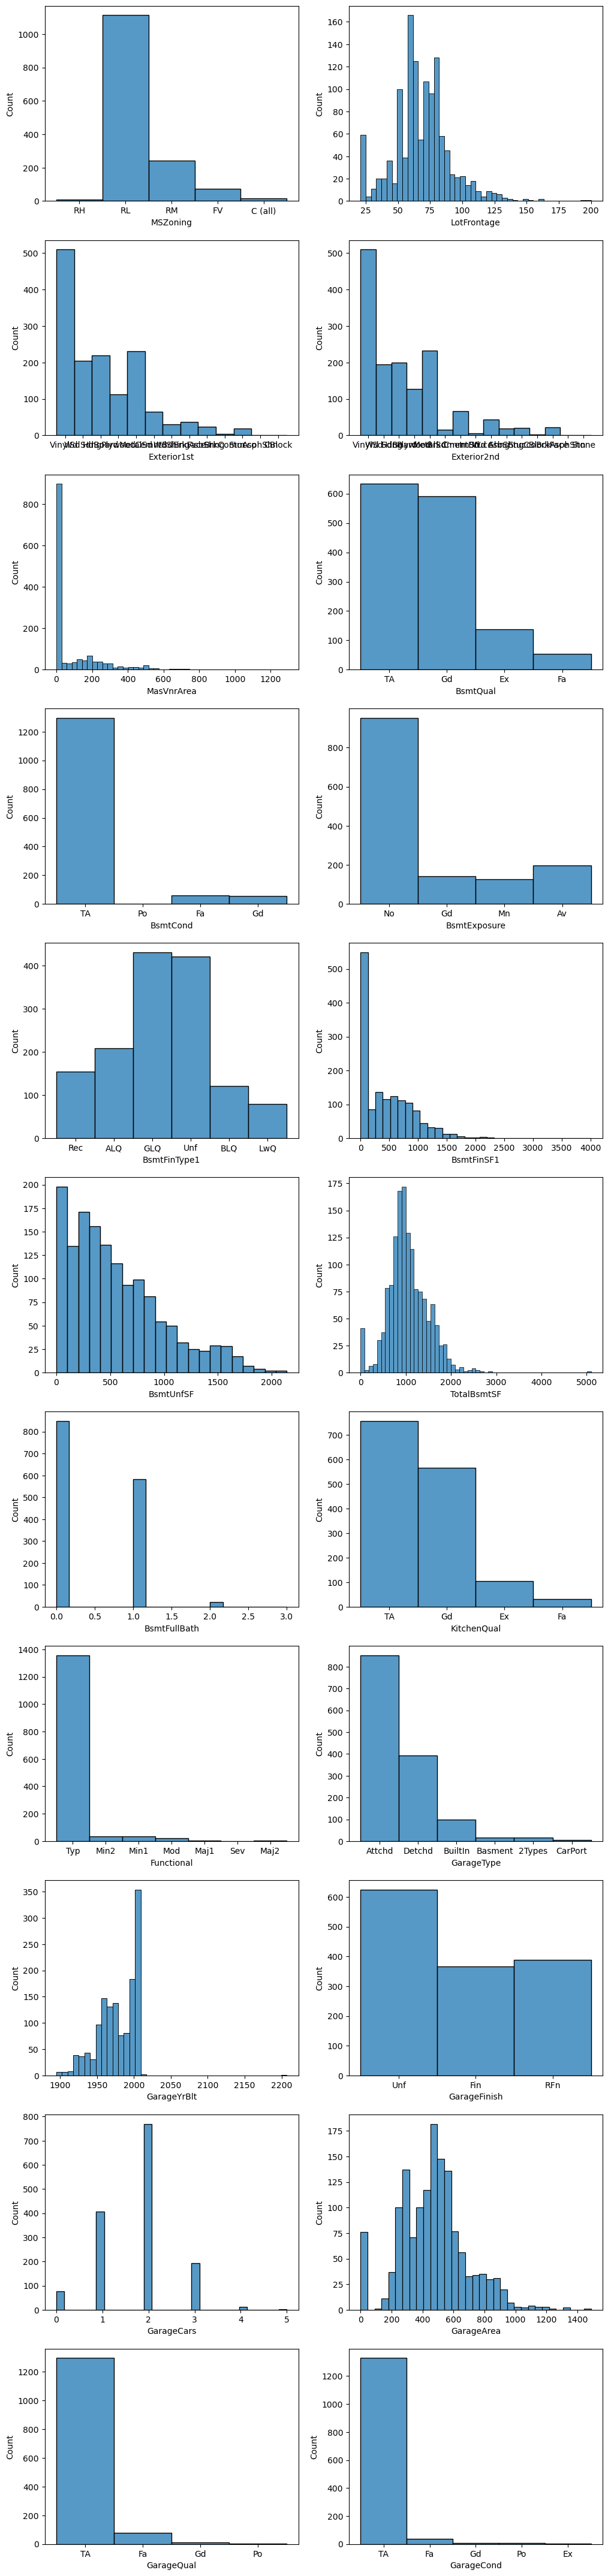

In [33]:
# Se hace una funcion para graficar cada columna con valores nulos para decidir como se imputan esos valores
def graf_imp_test(lista):
    from math import ceil
    cant_col = 2
    filas = ceil(len(lista) / cant_col)
    fig, axs = plt.subplots(nrows=filas, ncols=cant_col, figsize= (12, 5*filas))
    idx = 0
    for i in range(filas):
        for j in range(cant_col):
            if idx < len(lista):
                col = lista[idx]
                sns.histplot(x=test[col], data=test, ax=axs[i][j])
                idx += 1
    plt.show()


graf_imp_test(lista_null)

In [34]:
# Se hace  una lista con las columnas categoricas y otra con las columnas numericas y se imputan los valores

test_imp = test[lista_null]
lista_test_cat  = list(test_imp.select_dtypes(include='object').columns)
lista_test_num = list(test_imp.select_dtypes(include=np.number).columns)


def imp_cat (lista_cat):
    test.loc[:, lista_cat] = test[lista_cat].fillna(test[lista_cat].mode().iloc[0])
imp_cat(lista_test_cat)


for col1 in lista_test_num:
    test[col1].fillna(test[col1].median(), inplace=True)
    
print(test.isna().sum().sort_values(ascending=False))

MSZoning         0
Fireplaces       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
BsmtFullBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
GarageType       0
HeatingQC        0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
ScreenPorch      0
PoolArea         0
CentralAir       0
Heating          0
LotFrontage      0
RoofStyle        0
LotArea          0
LotShape         0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofMatl         0
TotalBsmtSF      0
Exterior1st      0
Exterior2nd      0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual    

In [35]:
# Se codifica y estandariza test
label = LabelEncoder()
test = test.apply(label.fit_transform)

columns = test.columns
scaler=StandardScaler()
test[columns] = scaler.fit_transform(test[columns])
test.head()

,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,...,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,-1.501777,0.606298,0.836391,0.742620,0.572445,-0.207992,-0.105672,-1.193183,-0.426625,-0.431830,...,1.410079,0.250409,0.186902,0.339114,0.320534,-0.749805,-0.387759,1.151627,-0.057729,0.201383
1462,-0.039098,0.657734,1.440233,-1.384637,-1.950811,-0.207992,-0.105672,-0.056113,-0.426625,-0.431830,...,-0.930475,0.250409,0.186902,0.339114,2.472075,-0.254761,-0.387759,-0.287195,-0.057729,0.201383
1463,-0.039098,0.297685,1.385338,-1.384637,0.572445,-0.207992,-0.784114,-0.056113,-0.426625,0.920188,...,0.002415,0.250409,0.186902,0.339114,1.166807,-0.296014,-0.387759,-0.287195,-0.057729,0.201383
1464,-0.039098,0.503427,0.222861,-1.384637,0.572445,-0.207992,-0.784114,-0.056113,-0.426625,0.920188,...,-0.089208,0.250409,0.186902,0.339114,2.386013,-0.254761,-0.387759,-0.287195,-0.057729,0.201383
1465,-0.039098,-1.296818,-1.291588,-1.384637,0.572445,-0.207992,1.590431,-0.056113,2.866737,-0.431830,...,0.160673,0.250409,0.186902,0.339114,-0.755237,0.652821,-0.387759,1.871038,-0.057729,0.201383


In [36]:
# Se entrena el modelo
dt =CatBoostRegressor(random_state=42)
dt.fit(train, y_train)

Learning rate set to 0.043237
0:	learn: 77055.5742584	total: 5.2ms	remaining: 5.19s
1:	learn: 74909.9397583	total: 9.48ms	remaining: 4.73s
2:	learn: 73046.3000080	total: 14.2ms	remaining: 4.71s
3:	learn: 71268.7845162	total: 18.9ms	remaining: 4.72s
4:	learn: 69327.1322729	total: 22.9ms	remaining: 4.56s
5:	learn: 67812.6455420	total: 26.7ms	remaining: 4.43s
6:	learn: 66049.5140633	total: 30.5ms	remaining: 4.33s
7:	learn: 64478.0035832	total: 33.9ms	remaining: 4.2s
8:	learn: 62752.7925819	total: 37.2ms	remaining: 4.1s
9:	learn: 61243.7790912	total: 40.4ms	remaining: 4s
10:	learn: 59620.9224169	total: 43.7ms	remaining: 3.92s
11:	learn: 58218.7155073	total: 47ms	remaining: 3.87s
12:	learn: 56871.7905360	total: 50.3ms	remaining: 3.82s
13:	learn: 55651.3398736	total: 53.8ms	remaining: 3.79s
14:	learn: 54365.8306563	total: 57ms	remaining: 3.74s
15:	learn: 53130.8368039	total: 60.1ms	remaining: 3.7s
16:	learn: 51946.5406647	total: 63.7ms	remaining: 3.68s
17:	learn: 50913.5210522	total: 68ms	re

167:	learn: 18069.5004747	total: 496ms	remaining: 2.46s
168:	learn: 18036.5257669	total: 500ms	remaining: 2.46s
169:	learn: 18010.9395715	total: 503ms	remaining: 2.46s
170:	learn: 17964.9814055	total: 506ms	remaining: 2.45s
171:	learn: 17899.3430880	total: 508ms	remaining: 2.45s
172:	learn: 17865.6840052	total: 511ms	remaining: 2.44s
173:	learn: 17839.0673010	total: 514ms	remaining: 2.44s
174:	learn: 17806.8320546	total: 516ms	remaining: 2.43s
175:	learn: 17766.6699442	total: 519ms	remaining: 2.43s
176:	learn: 17737.0867574	total: 522ms	remaining: 2.42s
177:	learn: 17701.4532761	total: 524ms	remaining: 2.42s
178:	learn: 17656.4517489	total: 527ms	remaining: 2.42s
179:	learn: 17636.9062149	total: 530ms	remaining: 2.41s
180:	learn: 17615.2329259	total: 532ms	remaining: 2.41s
181:	learn: 17584.0589496	total: 535ms	remaining: 2.4s
182:	learn: 17521.6983717	total: 538ms	remaining: 2.4s
183:	learn: 17481.9602948	total: 541ms	remaining: 2.4s
184:	learn: 17458.8847776	total: 543ms	remaining: 2

332:	learn: 13387.1221901	total: 955ms	remaining: 1.91s
333:	learn: 13370.9052771	total: 958ms	remaining: 1.91s
334:	learn: 13362.8126813	total: 961ms	remaining: 1.91s
335:	learn: 13338.3221191	total: 964ms	remaining: 1.9s
336:	learn: 13321.2943063	total: 967ms	remaining: 1.9s
337:	learn: 13301.9983321	total: 969ms	remaining: 1.9s
338:	learn: 13274.9576944	total: 972ms	remaining: 1.9s
339:	learn: 13264.4516109	total: 975ms	remaining: 1.89s
340:	learn: 13231.2979624	total: 977ms	remaining: 1.89s
341:	learn: 13217.9111332	total: 980ms	remaining: 1.89s
342:	learn: 13202.7677021	total: 982ms	remaining: 1.88s
343:	learn: 13175.7368159	total: 985ms	remaining: 1.88s
344:	learn: 13141.9105353	total: 988ms	remaining: 1.88s
345:	learn: 13110.7301926	total: 991ms	remaining: 1.87s
346:	learn: 13091.7726573	total: 993ms	remaining: 1.87s
347:	learn: 13074.9988185	total: 996ms	remaining: 1.86s
348:	learn: 13063.5865612	total: 998ms	remaining: 1.86s
349:	learn: 13042.1932402	total: 1s	remaining: 1.86s

509:	learn: 10525.9360262	total: 1.46s	remaining: 1.4s
510:	learn: 10507.6245836	total: 1.46s	remaining: 1.4s
511:	learn: 10494.2668629	total: 1.46s	remaining: 1.4s
512:	learn: 10492.0047637	total: 1.47s	remaining: 1.39s
513:	learn: 10472.0085085	total: 1.47s	remaining: 1.39s
514:	learn: 10465.2317709	total: 1.47s	remaining: 1.39s
515:	learn: 10464.3768168	total: 1.48s	remaining: 1.38s
516:	learn: 10463.0011971	total: 1.48s	remaining: 1.38s
517:	learn: 10441.4664960	total: 1.48s	remaining: 1.38s
518:	learn: 10423.0564447	total: 1.48s	remaining: 1.37s
519:	learn: 10405.6861531	total: 1.49s	remaining: 1.37s
520:	learn: 10390.0100759	total: 1.49s	remaining: 1.37s
521:	learn: 10375.9440490	total: 1.49s	remaining: 1.37s
522:	learn: 10368.0430624	total: 1.49s	remaining: 1.36s
523:	learn: 10355.5210491	total: 1.5s	remaining: 1.36s
524:	learn: 10354.3427029	total: 1.5s	remaining: 1.36s
525:	learn: 10331.8923321	total: 1.5s	remaining: 1.35s
526:	learn: 10318.7676604	total: 1.5s	remaining: 1.35s

674:	learn: 8684.9494083	total: 1.92s	remaining: 922ms
675:	learn: 8684.2310317	total: 1.92s	remaining: 920ms
676:	learn: 8671.1811538	total: 1.92s	remaining: 917ms
677:	learn: 8657.8424902	total: 1.93s	remaining: 914ms
678:	learn: 8656.8846983	total: 1.93s	remaining: 912ms
679:	learn: 8646.9238425	total: 1.93s	remaining: 909ms
680:	learn: 8641.0911217	total: 1.93s	remaining: 906ms
681:	learn: 8628.9591816	total: 1.94s	remaining: 903ms
682:	learn: 8612.4253586	total: 1.94s	remaining: 900ms
683:	learn: 8604.6098100	total: 1.94s	remaining: 897ms
684:	learn: 8593.1452513	total: 1.94s	remaining: 894ms
685:	learn: 8582.9507095	total: 1.95s	remaining: 891ms
686:	learn: 8564.6483448	total: 1.95s	remaining: 888ms
687:	learn: 8551.1299453	total: 1.95s	remaining: 886ms
688:	learn: 8546.6701696	total: 1.96s	remaining: 883ms
689:	learn: 8530.4690495	total: 1.96s	remaining: 880ms
690:	learn: 8522.6978685	total: 1.96s	remaining: 877ms
691:	learn: 8514.8432496	total: 1.96s	remaining: 874ms
692:	learn

848:	learn: 7250.0119619	total: 2.42s	remaining: 430ms
849:	learn: 7241.5656903	total: 2.42s	remaining: 427ms
850:	learn: 7233.1881330	total: 2.42s	remaining: 424ms
851:	learn: 7225.8910776	total: 2.42s	remaining: 421ms
852:	learn: 7221.0296096	total: 2.43s	remaining: 418ms
853:	learn: 7212.9479342	total: 2.43s	remaining: 416ms
854:	learn: 7208.5454710	total: 2.43s	remaining: 413ms
855:	learn: 7197.9655665	total: 2.44s	remaining: 410ms
856:	learn: 7196.0357269	total: 2.44s	remaining: 407ms
857:	learn: 7186.3269629	total: 2.44s	remaining: 404ms
858:	learn: 7179.8192482	total: 2.44s	remaining: 401ms
859:	learn: 7174.8868634	total: 2.45s	remaining: 398ms
860:	learn: 7165.7017042	total: 2.45s	remaining: 396ms
861:	learn: 7153.7274708	total: 2.45s	remaining: 393ms
862:	learn: 7144.6934923	total: 2.46s	remaining: 390ms
863:	learn: 7133.2387746	total: 2.46s	remaining: 387ms
864:	learn: 7127.6324986	total: 2.46s	remaining: 384ms
865:	learn: 7116.7770731	total: 2.46s	remaining: 381ms
866:	learn

In [37]:
# Se realizan las predicciones
preds = dt.predict(test)
rta = pd.DataFrame({'Id': test.index, 'SalePrice': preds})
rta.to_csv('house_rep.csv', index=False)

## Score = 0.12918